### Import packages

In [59]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
from sklearn import metrics

### Import data

In [46]:
df_weekly = pd.read_csv(r'C:\Users\lombarlp1\my_env\Github\Introduction-to-Statistical-Learning\Data sets\Weekly.csv')

### Show the dataframe

In [47]:
df_weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


### Let's change the *Direction* into 1 for up and 0 for down. 

In [48]:
df_weekly['Direction_Up'] = np.where(df_weekly['Direction'] == 'Up',1,0)
df_weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction_Up
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1
...,...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up,1
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up,1
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up,1
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up,1


### Drop the direction and then plot via seaborn.

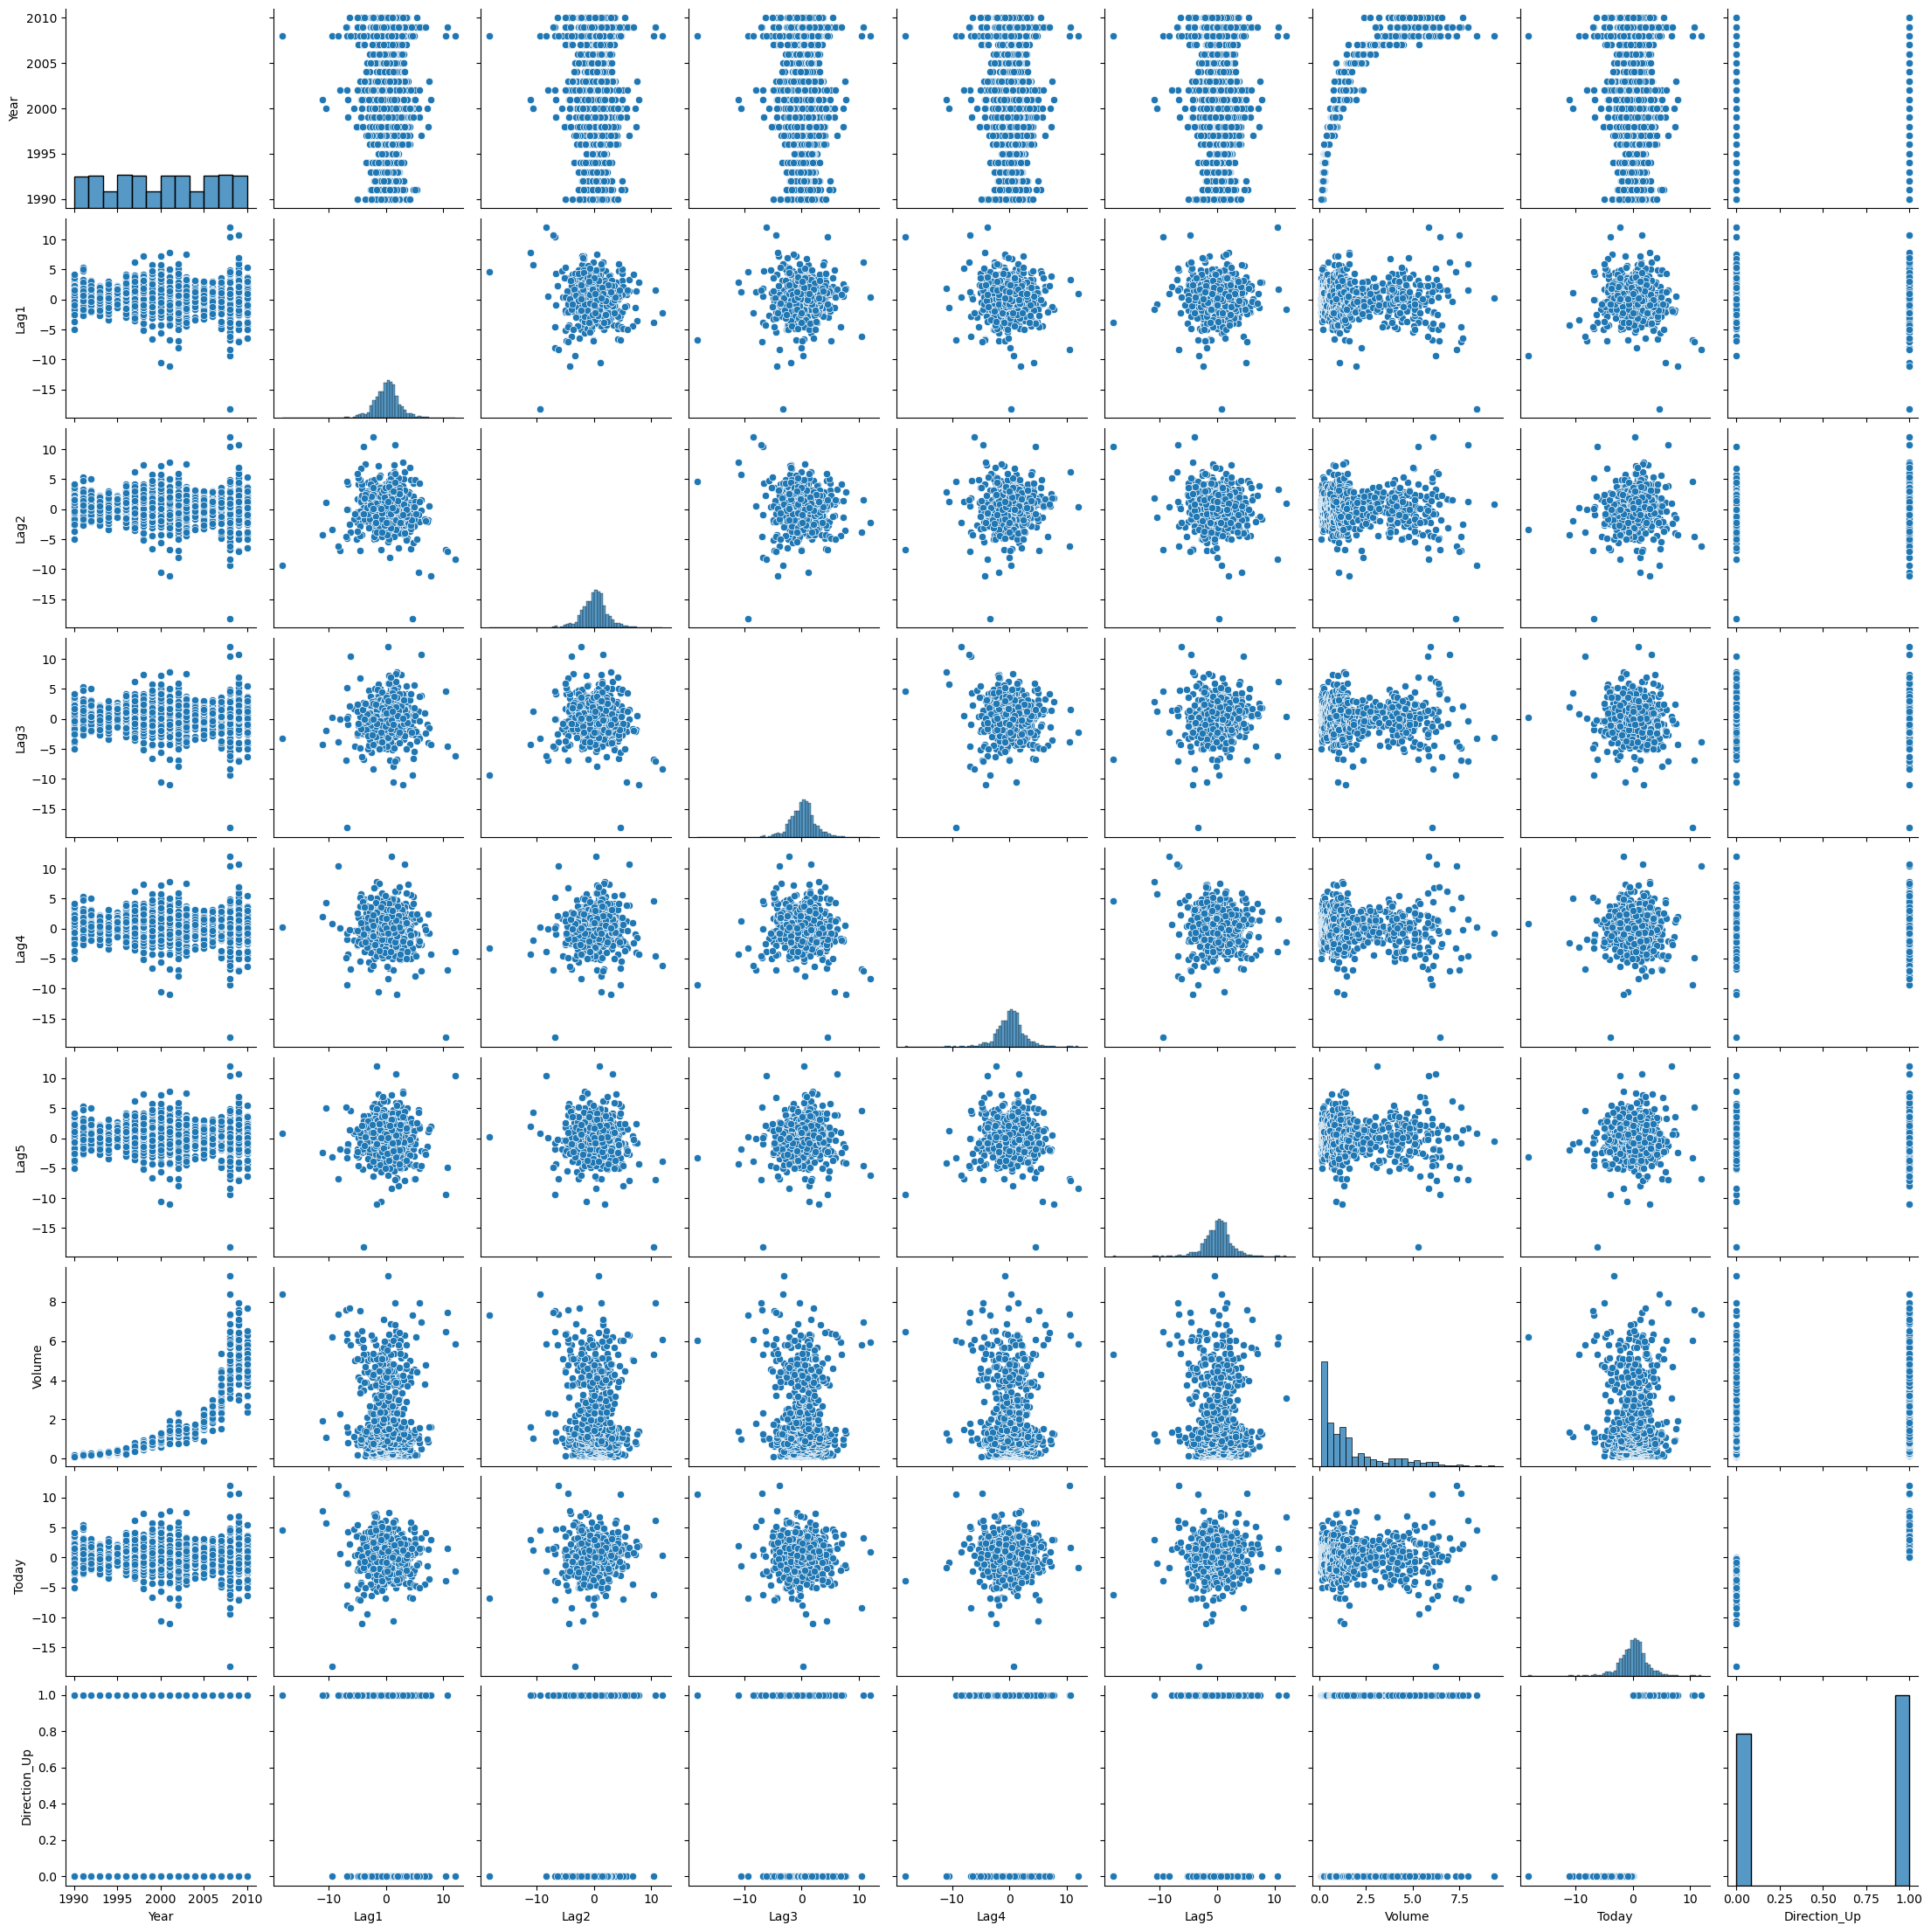

In [49]:
df_weekly_plot = df_weekly.drop(columns=['Direction'])

sns.pairplot(df_weekly_plot)

### Draw a correlation matrix

C:\Users\lombarlp1\AppData\Local\Temp\ipykernel_4276\3178462936.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_weekly.corr().abs()


<Axes: >

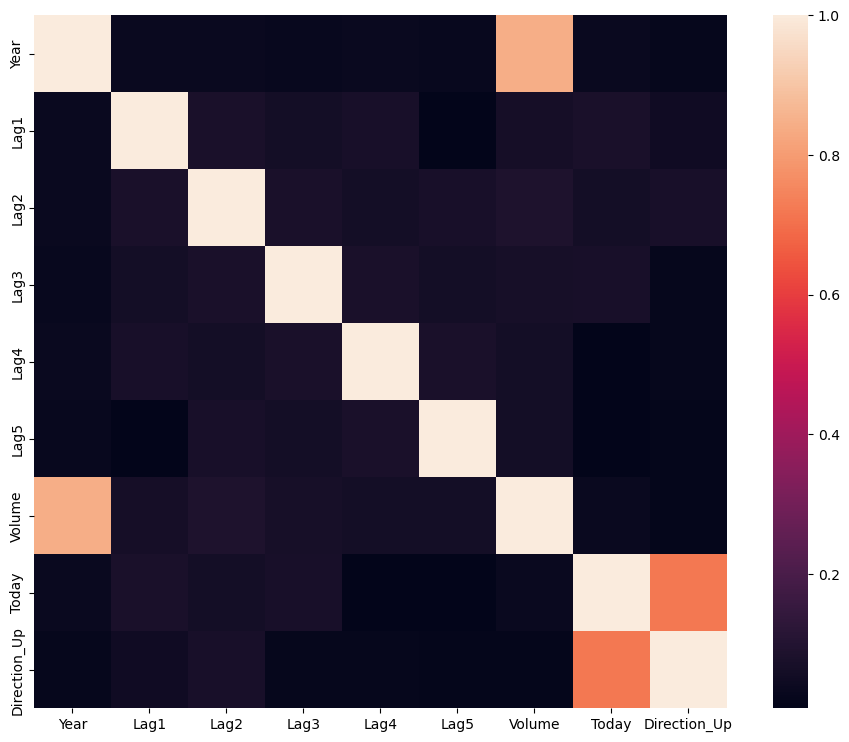

In [50]:
corr_matrix = df_weekly.corr().abs()
fig, ax     = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=1, square=True)

### Show some other numerical statistics

In [51]:
df_weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Up
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899,0.555556
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927,0.497132
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000,0.000000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000,0.000000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000,1.000000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000,1.000000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000,1.000000


I do not really see any trends when looking at the pairplots other than the volume of the trades going up exponentially as the year increases. 

### (b) Use the full data set to perform a logistic regression with *Direction* as the response and the five lag variables plus *Volume* as predictors. Use the summary function to print the results. Do any of the predictors appear to be significant. If so, which ones?  

In [52]:
# Fit a logistic regression to predict Direction using Lag1 through Lag5 and Volume.
f = 'Direction_Up ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume'

# Set up the model
model_logist = sm.Logit.from_formula(formula=f, data=df_weekly)
results_logist = model_logist.fit()

display(results_logist.summary())

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Direction_Up   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Mon, 25 Mar 2024   Pseudo R-squ.:                0.006580
Time:                        13:52:34   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

### The following values have p-values smaller than 0.05.

In [58]:
display(pd.DataFrame({'p>|z|': results_logist.pvalues[results_logist.pvalues < 0.05].drop('Intercept')}))

,p>|z|
Lag2,0.029601


### (c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

### Let's define a function to create a confusion matrix and calculate the confusion matrix statistics, such as accuracy, precision, recall/sensitivity etc. 

### Define a function to calculate the confusion matrix and related metrics

In [73]:
cm = results_logist.pred_table(threshold=0.5)
cm

array([[ 54., 430.],
       [ 48., 557.]])

In [70]:
def confusion_matrix(confusion_matrix):
    """Return a confusion matrix that is formatted neatly"""
    confusion_df = pd.DataFrame({'Predicted 0': np.append(confusion_matrix[:, 0], confusion_matrix.sum(axis=0)[0]),
                                 'Predicted 1': np.append(confusion_matrix[:, 1], confusion_matrix.sum(axis=0)[1]),
                                 'Total': np.append(confusion_matrix.sum(axis=1), ''),
                                 '': ['Actual 0', 'Actual 1', 'Total']}).set_index('')
    return confusion_df

In [71]:
confusion_matrix(results_logist.pred_table(threshold=0.5))

,Predicted 0,Predicted 1,Total
,,,
Actual 0,54.0,430.0,484.0
Actual 1,48.0,557.0,605.0
Total,102.0,987.0,
